In [50]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import seaborn as sns
from numpyro.diagnostics import hpdi

A slightly modified version of <a>https://james-brennan.github.io/posts/horseshoe/</a>.

<h1> Generate Data </h1>

In [51]:
from sklearn.datasets import make_sparse_coded_signal

y, X, beta = make_sparse_coded_signal(n_samples=1,
                                   n_components=50,
                                   n_features=100,
                                   n_nonzero_coefs=20,
                                   random_state=0)

X = X.T 
print(jnp.equal(y, X@beta)) # assert y = X @ beta

# add some noise to y
y += 0.1 * random.normal(key=random.PRNGKey(1), shape=(len(y),))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


<h2> Define the Model </h2>

Horseshoe prior:
$$ \tau \sim C^+(0, 1)$$
$$ \lambda_i \sim C^+(0, 1)$$
$$ \beta_i \sim N(0, \tau^2 \lambda_i^2) $$
$$ y \sim N(\beta, \sigma^2) $$

where $\beta$ is the average of all $\beta_i$ and $\sigma = 0.1$ in this example.

In [52]:
def horseshoe_linear_model(y=None, X=None, y_sigma=0.1):
    '''
    Parameters:
       array y: dependent variable
       array X: independent variable
       int y_sigma: stdev of y
    '''
    n_predictors = X.shape[1] # 50 predictors (length of beta)
    Tau = numpyro.sample('tau', dist.HalfCauchy(1))
    with numpyro.plate('data', n_predictors): # for i in range(n_predictors):
        Lambda = numpyro.sample('lambda', dist.HalfCauchy(1)) 
        Beta = numpyro.sample('beta', dist.Normal(0, Tau*Lambda))
    mu = jnp.dot(X, Beta) 
    numpyro.sample('y', dist.Normal(mu, y_sigma), obs=y)

<h1> Run and Evaluate MCMC </h1>

In [53]:
mcmc = MCMC(
    NUTS(horseshoe_linear_model),
    num_warmup=500,
    num_samples=1000,
    num_chains = 3
)
mcmc.run(random.PRNGKey(5), y=y, X=X)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_12174/2035845835.py:1: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 2577.79it/s, 127 steps of size 3.71e-02. acc. prob=0.73]


We can inspect our model's learned parameters using `az.plot_trace`. The `compact` argument allows us to plot multiple variables in one plot.

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

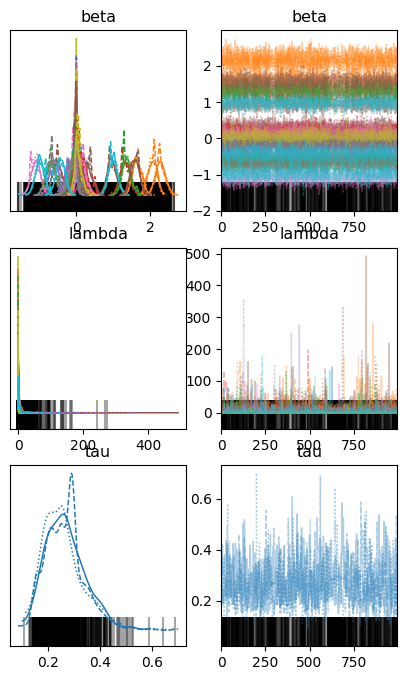

In [54]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(5,8))

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

In [55]:
az.ess(data)

<xarray.Dataset> Size: 2kB
Dimensions:       (beta_dim_0: 50, lambda_dim_0: 50)
Coordinates:
  * beta_dim_0    (beta_dim_0) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * lambda_dim_0  (lambda_dim_0) int64 400B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
Data variables:
    beta          (beta_dim_0) float64 400B 275.4 1.131e+03 ... 939.0 361.6
    lambda        (lambda_dim_0) float64 400B 1.045e+03 835.7 ... 1.028e+03
    tau           float64 8B 462.5

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [56]:
az.rhat(data)

<xarray.Dataset> Size: 2kB
Dimensions:       (beta_dim_0: 50, lambda_dim_0: 50)
Coordinates:
  * beta_dim_0    (beta_dim_0) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * lambda_dim_0  (lambda_dim_0) int64 400B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
Data variables:
    beta          (beta_dim_0) float64 400B 1.012 1.006 1.011 ... 1.008 1.011
    lambda        (lambda_dim_0) float64 400B 1.001 1.003 1.008 ... 1.001 1.011
    tau           float64 8B 1.005

<h1> Results </h1>

In [66]:
posterior_samples = mcmc.get_samples()

`posterior_samples` is a dictionary with our sample values of $\beta$, $\tau$, and $\lambda$. For example, since $\beta$ is a length 50 vector, `posterior_samples['beta']` is a $1000 \times 50$ matrix.

In [58]:
beta_mu = jnp.mean(posterior_samples['beta'], axis = 0)
print(beta_mu.shape)

(50,)


We take the mean across all 1000 samples, resulting in a length 50 vector.

Text(0, 0.5, '$\\beta_i$')

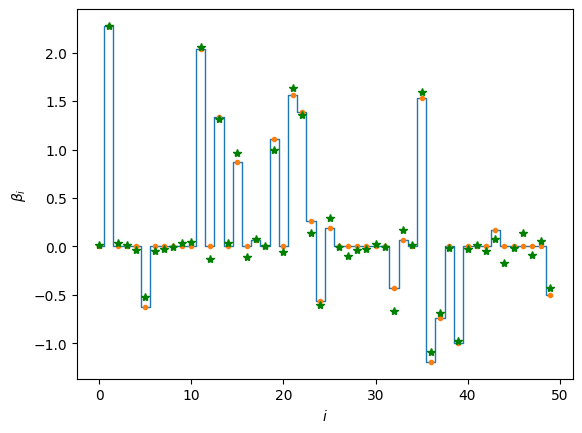

In [59]:
plt.step(range(len(beta)), beta,  where='mid', lw=1) # blue line
plt.plot(range(len(beta)), beta, '.') # actual values
plt.plot(range(len(beta)), beta_mu, 'g*') # predicted values
plt.xlabel(r'$i$')
plt.ylabel(r'$\beta_i$')

In [60]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.02      0.09      0.01     -0.10      0.21    194.62      1.02
   beta[1]      2.27      0.13      2.26      2.05      2.47   1118.36      1.00
   beta[2]      0.03      0.08      0.02     -0.08      0.20    900.94      1.01
   beta[3]      0.02      0.09      0.01     -0.12      0.16   1076.82      1.00
   beta[4]     -0.03      0.09     -0.02     -0.19      0.10    924.58      1.01
   beta[5]     -0.52      0.13     -0.52     -0.75     -0.31    827.26      1.00
   beta[6]     -0.05      0.09     -0.03     -0.21      0.09   1241.41      1.00
   beta[7]     -0.02      0.09     -0.01     -0.17      0.12    873.33      1.00
   beta[8]     -0.00      0.08     -0.00     -0.14      0.13   1355.87      1.00
   beta[9]      0.04      0.10      0.03     -0.11      0.21   1029.71      1.01
  beta[10]      0.05      0.10      0.03     -0.10      0.23    840.82      1.00
  beta[11]      2.06      0

<h1> Comparison with Linear Model</h1>

Prior: 
$$\beta_i \sim \text{Uniform}(-1000, 1000)$$
$$y \sim N(\beta, \sigma)$$

In [61]:
def linear_model(y=None, X=None, y_sigma=0.1):
    n_predictors = X.shape[1]
    with numpyro.plate('beta plate', n_predictors):
        Beta = numpyro.sample('Beta', dist.Uniform(-1000, 1000))
    mu = jnp.dot(X, Beta)
    numpyro.sample('y', dist.Normal(mu, y_sigma), obs=y)

linear_mcmc = MCMC(
    NUTS(linear_model),
    num_warmup = 500,
    num_samples = 1000)
linear_mcmc.run(random.PRNGKey(3), y=y, X=X)
linear_posterior_samples = linear_mcmc.get_samples()
linear_beta_mu = jnp.mean(linear_posterior_samples['Beta'], axis=0)

sample: 100%|██████████| 1500/1500 [00:00<00:00, 1554.17it/s, 15 steps of size 1.91e-02. acc. prob=0.86]


array([[<Axes: title={'center': 'Beta'}>,
        <Axes: title={'center': 'Beta'}>]], dtype=object)

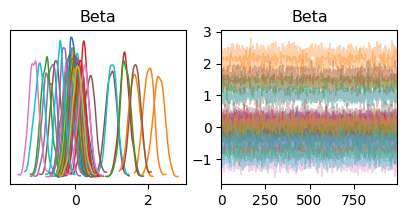

In [62]:
data = az.from_numpyro(linear_mcmc)
az.plot_trace(data, compact=True, figsize=(5,2))

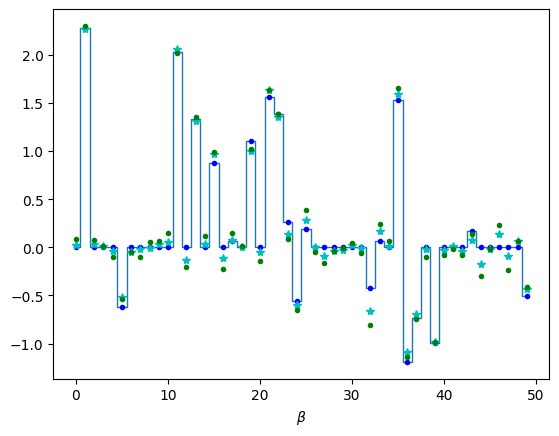

In [63]:
plt.step(range(len(beta)), beta,  where='mid', lw=1) # blue line
plt.plot(range(len(beta)), beta, 'b.') # actual values
plt.plot(range(len(beta)), beta_mu, 'c*') # predicted values
plt.xlabel(r'$\beta$')
plt.plot(range(len(beta)), linear_beta_mu, 'g.')

In [64]:
linear_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Beta[0]      0.09      0.14      0.09     -0.13      0.34    665.31      1.00
   Beta[1]      2.30      0.16      2.30      2.04      2.57    703.24      1.00
   Beta[2]      0.08      0.14      0.07     -0.15      0.31    509.90      1.00
   Beta[3]      0.02      0.14      0.02     -0.21      0.24    888.69      1.00
   Beta[4]     -0.10      0.15     -0.10     -0.32      0.16    793.38      1.00
   Beta[5]     -0.54      0.14     -0.54     -0.77     -0.32    685.79      1.00
   Beta[6]     -0.05      0.13     -0.05     -0.29      0.15    939.81      1.00
   Beta[7]     -0.10      0.13     -0.09     -0.30      0.12    808.53      1.00
   Beta[8]      0.06      0.15      0.06     -0.21      0.29    482.50      1.00
   Beta[9]      0.07      0.14      0.07     -0.16      0.30    789.98      1.00
  Beta[10]      0.15      0.17      0.15     -0.12      0.42    665.23      1.00
  Beta[11]      2.02      0

<h1> Adding Regularization</h1>

In [65]:
def regularized_horseshoe(y=None, X=None, y_sigma=0.1):
    '''
    Parameters:
       array y: dependent variable
       array X: independent variable
       int y_sigma: stdev of y
    '''
    n_predictors = X.shape[1] # 50 predictors (length of beta)
    # Tau = numpyro.sample('tau', dist.HalfCauchy(1))
    # with numpyro.plate('data', n_predictors): # for i in range(n_predictors):
    #     Lambda = numpyro.sample('lambda', dist.HalfCauchy(1)) 
    #     Beta = numpyro.sample('beta', dist.Normal(0, Tau*Lambda))
    # mu = jnp.dot(X, Beta) 
    # numpyro.sample('y', dist.Normal(mu, y_sigma), obs=y)
    